In [1]:
import keras
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, Layer, Input, MaxPool2D, Activation, Flatten, Dense, Dropout, Input
from keras.activations import relu
from keras import Sequential
from imgaug import augmenters
import ntpath
import os
import matplotlib.image as img
import cv2
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
import gc

In [2]:
config = {
    'delta_correction':0.25,
    'guassian_noise_sigma':0.2,
    'width': 100,
    'height': 100,
    'batch_size': 64,
    'bias': 0.25
}

In [3]:
def augment_image(image, steering):
    if np.random.choice([True, False]):
        pan = augmenters.Affine(translate_percent={'X':(-0.1, 0.1), 'y':(-0.1, 0.1)})
        image = pan.augment_image(image)
    if np.random.choice([True, False]):
        zoom = augmenters.Affine(scale=(1, 1.2))
        image = zoom.augment_image(image)
    if np.random.choice([True, False]):
        brightness = augmenters.Multiply((0.4, 1.2))
        image = brightness.augment_image(image)
    if np.random.choice([True, False]):
        image = cv2.flip(image, 1)
        steering = -steering
    return image, steering

In [4]:
def load_image_steering(datadir, df):
    """Get img and steering data into arrays"""
    datadir = datadir + '/IMG'
    images = []
    steerings = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        steering = indexed_data['steering']
        chosen_camera_angle = np.random.choice(['center', 'left', 'right'])
        if chosen_camera_angle == 'center':
            pass
        elif chosen_camera_angle == 'right':
            steering -= 0.15
        else:
            steering += 0.15
        path = os.path.join(datadir, indexed_data[chosen_camera_angle].strip())
        images.append(plt.imread(path))
        steerings.append(float(steering))
    return np.asarray(images), np.asarray(steerings)



In [5]:
def preprocess_image(image):
    #cropping useless information 
    image = image[60:135, :, :]
    #this help distincting between lanes and road
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.resize(image, (200, 66))
    image = image / 255
    return image
    

In [6]:
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images, steerings, batch_size=32, dim=(66, 200), n_channels=3,
                 shuffle=True, validation=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.steerings = steerings
        self.images = images
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.validation = validation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        images_temp = [self.images[k] for k in indexes]
        steerings_temp = [self.steerings[k] for k in indexes]
        # Generate data
        images, steerings = self.__data_generation(images_temp, steerings_temp)
#         del indexes
#         del images_temp
#         del steerings_temp
        return images, steerings

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    def __data_generation(self, images_temp, steerings_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        images = np.empty((self.batch_size, *self.dim, self.n_channels))
        steerings = np.empty((self.batch_size), dtype=float)
        
        # Generate data
        for i, data in enumerate(zip(images_temp, steerings_temp)):
            image, steering = data
            # Store sample
            if not self.validation:
                image, steering = augment_image(image, steering)
            image = preprocess_image(image)
            images[i, ] = image
            steerings[i] = steering
        return images, steerings

In [7]:
def create_nvidia_model():
    model = Sequential([
        Input(shape=(66, 200, 3)),
        Conv2D(24, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='elu'),
        Dropout(0.2),
        Conv2D(36, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='elu'),
        Dropout(0.2),
        Conv2D(48, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='elu'),
        Dropout(0.2),
        Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='elu'),
        Dropout(0.2),
        Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='elu'),
        Dropout(0.2),
        Flatten(),
        Dense(100, activation='elu'),
        Dropout(0.5),
        Dense(50, activation='elu'),
        Dropout(0.5),
        Dense(10, activation='elu'),
        Dropout(0.5),
        Dense(1, activation='linear'),
    ])
    
    model.compile(optimizer='adam',loss='mse')
    return model

In [8]:
def make_histogram(foo, num_bins):
    hist, bins = np.histogram(foo, num_bins)
    return hist, bins

In [9]:
def balance_data(df, num_bins=31, samples_per_bin=500, debug=False):
    hist, bins = make_histogram(df['steering'], num_bins)
    center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0
    if debug:
        plt.bar(center, hist, width=0.05)
        plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))
        plt.show()
    if debug:
        print('Total data: {0}'.format(len(df)))
    
    remove_list = []
    for j in range(num_bins):
        list_ = []
        for i in range(df.shape[0]):
            steering_angle = df['steering'][i]
            if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
                list_.append(i)
        list_ = shuffle(list_)
        list_ = list_[samples_per_bin:]
        remove_list.extend(list_)

    df.drop(df.index[remove_list], inplace=True)
    if debug:
        print('Removed: {0}'.format(len(remove_list)))
        print('Remaining: {0}'.format(df.shape[0]))
    if debug:
        hist, _ = make_histogram(df['steering'], num_bins)
        plt.bar(center, hist, width=0.05)
        plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))
        plt.show()

In [10]:
def get_path_tail(path):
    _, tail = ntpath.split(path)
    return tail


def load_data(datadir, columns):
    df = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
    for i in range(3):
        df[columns[i]] = df[columns[i]].apply(get_path_tail)
    return df

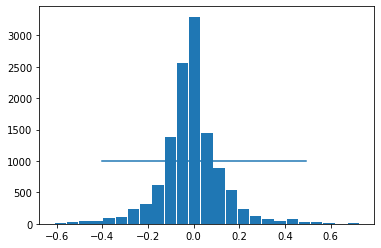

Total data: 12284
Removed: 4689
Remaining: 7595


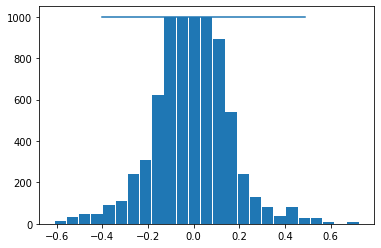

In [11]:
datadir = '../input/udacityselfdrivingcar/two tracks'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df = load_data(datadir, columns)
balance_data(df,num_bins=25,samples_per_bin=1000,debug=True)
images, steerings = load_image_steering(datadir, df)

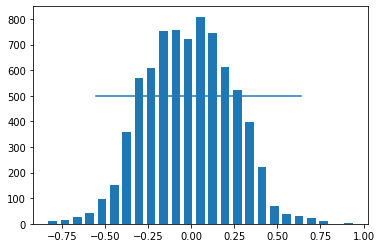

In [12]:
hist, bins = make_histogram(steerings, num_bins=25)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0
plt.bar(center, hist, width=0.05)
plt.plot((np.min(steerings), np.max(steerings)), (500, 500))
plt.show()

-0.047916700000000007


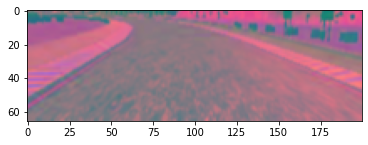

In [13]:
index = np.random.randint(0, images.shape[0] - 1)
steering = steerings[index]
image = images[index]
image, steering = augment_image(image, steering)
image = preprocess_image(image)
plt.imshow(image)
print(steering)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, steerings, test_size=0.3, random_state=42)
del images
del steerings
print(f'X_training_size: {X_train.shape}')
print(f'X_testing_size: {X_test.shape}')

print(f'y_training_size: {y_train.shape}')
print(f'y_testing_size: {y_test.shape}')

X_training_size: (5316, 160, 320, 3)
X_testing_size: (2279, 160, 320, 3)
y_training_size: (5316,)
y_testing_size: (2279,)


In [15]:
model = create_nvidia_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
dropout (Dropout)            (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 22, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         2

2022-05-14 22:25:10.117608: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
class MyCustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [17]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_freq="epoch",
    save_best_only=True)

train_generator = DataGenerator(X_train, y_train, batch_size=100, dim=(66, 200), n_channels=3)
validation_generator = DataGenerator(X_test, y_test, batch_size=100, dim=(66, 200), n_channels=3, validation=True)

# 20 epoch is good 
history = model.fit(
    train_generator,
    steps_per_epoch=300,
    epochs = 20,
    validation_data=validation_generator,
    validation_steps=10,
    max_queue_size=10,
    workers=3,
    use_multiprocessing=True,
    callbacks=[model_checkpoint_callback, MyCustomCallback()],
)



2022-05-14 22:25:10.772851: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
300/300 [==============================] - 91s 298ms/step - loss: 0.0563 - val_loss: 0.0199
Epoch 2/20
300/300 [==============================] - 89s 295ms/step - loss: 0.0262 - val_loss: 0.0170
Epoch 3/20
300/300 [==============================] - 88s 291ms/step - loss: 0.0231 - val_loss: 0.0140
Epoch 4/20
300/300 [==============================] - 88s 289ms/step - loss: 0.0212 - val_loss: 0.0128
Epoch 5/20
300/300 [==============================] - 91s 299ms/step - loss: 0.0203 - val_loss: 0.0127
Epoch 6/20
300/300 [==============================] - 87s 288ms/step - loss: 0.0195 - val_loss: 0.0115
Epoch 7/20
300/300 [==============================] - 87s 287ms/step - loss: 0.0191 - val_loss: 0.0125
Epoch 8/20
300/300 [==============================] - 87s 287ms/step - loss: 0.0185 - val_loss: 0.0125
Epoch 9/20
300/300 [==============================] - 89s 294ms/step - loss: 0.0180 - val_loss: 0.0103
Epoch 10/20
300/300 [==============================] - 89s 293ms/step - l

In [18]:
model.load_weights(checkpoint_filepath)

Text(0.5, 0, 'Epoch')

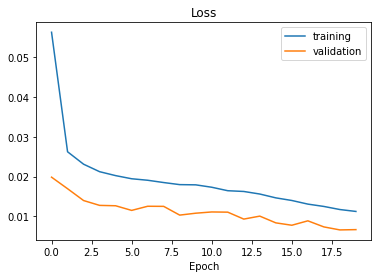

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

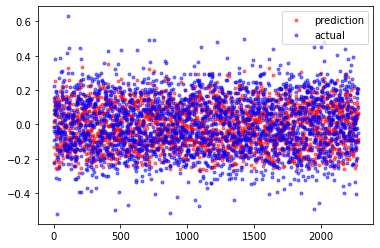

In [20]:
test = []
for image in X_test:
    image = preprocess_image(image)
    test.append(image)
test = np.asarray(test)
y_pred = model.predict(test)
plt.plot(y_pred, 'r.',alpha=0.5)
plt.plot(y_test, 'b.', alpha=0.5)
plt.legend(['prediction', 'actual'])
plt.show()
del test
del y_pred

In [21]:
model.save('model.h5', 'h5')

In [22]:
 import os
 os.chdir(r'/kaggle/working')
 from IPython.display import FileLink
 FileLink(r'model.h5')

/kaggle/working/model.h5